# Computer Vision Course (2024 Spring) Homework 3

---

## Problem 1. Text image understanding
To understand the semantic information of an image, it is important to combine different techniques in computer vision. In this problem, we will review the previously used tools in Unit II: Geometry and Unit III: Representation, then use **template matching** or **optical character recognition** (OCR) to understand the text images.

Assume that we have two sets of images, containing two famous poems written by Shakespeare. 
The first poem is pasted on a billboard with perspective transformation, as shown in `data/sonnet18_board.jpg`. And the second poem is clipped to four pieces with overlaps, as shown in `data/sonnet23_piece1.png`, `data/sonnet23_piece2.png`, `data/sonnet23_piece3.png`, and `data/sonnet23_piece4.png`. 
You should write code to firstly pre-process the images, and then try to locate the words and phrase of `data/template_love.png`, `data/template_summer.png`, and `data/template_eternal_summer.png` in the processed images via template matching or OCR. (100 points)

- Grading standards:
  - Transform the text region of the billboard image to eliminate the perspective effect. (20 points)
  - Image mosaic from the pieces of sonnet 23. (30 points)
  - Locate the words and phrase of the template images in the two generated images. (40 points)
  - Explain your method and discuss the results. (10 points)
  - **NOTE**: Please keep the output, e.g. the processed images, in the blocks when submitting this file. Otherwise, it's hard to correctly grade your work.

- Hints:
  - Perspective transformation: You can manually select points from the billboard image, then calculate the transformation matrix via `cv2.getPerspectiveTransform()`. The original shape of the text region is in a ratio of 80 to 139.
  - Image mosaic: You can use `cv2.ORB_create()` for local feature detection, `cv2.BFMatcher` for feature matching, `cv2.findHomography` for estimating homography matrix.
  - Image thresholding: https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
  - Template matching: https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html
  - OCR for python: `pytesseract`. You can use `pytesseract.image_to_string()`, `pytesseract.image_to_boxes()` or `pytesseract.image_to_data()` to recognize the text in the processed images.
  - **NOTE**: You are **NOT** necessarily required to implement both the template matching and the OCR for this problem. Either method is okay as long as you can successfully locate the template words/phrase in the processed images.

- Data:
  - Billboard image: `data/sonnet18_board.jpg`
  - Pieces of a poem: `data/sonnet23_piece1.png`, `data/sonnet23_piece2.png`, `data/sonnet23_piece3.png`, `data/sonnet23_piece4.png`
  - Template images: `data/template_love.png`, `data/template_summer.png`, `data/template_eternal_summer.png`

- Recommended environment:
  - `python==3.8`, `opencv-python>=4.3.0`, `numpy`, `matplotlib`, `pytesseract`.

---

Text(0.5, 1.0, 'This is an output demo.')

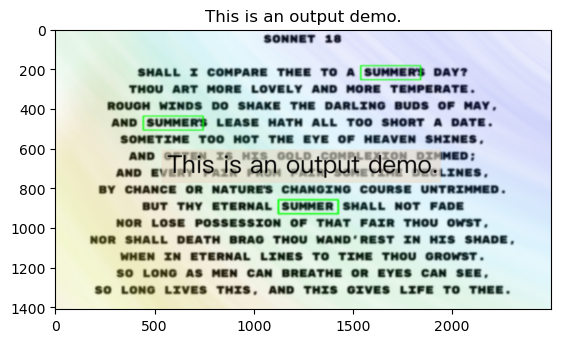

In [97]:
# An output demo (delete it when submitting your code)
import cv2
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(cv2.imread('./data/demo_output.png'))
plt.title('This is an output demo.')

### 1) Transform the text region of the billboard image to eliminate the perspective effect. (20 points)
Billboard image: `data/sonnet18_board.jpg`

Text(0.5, 1.0, 'Manually selected corner points.')

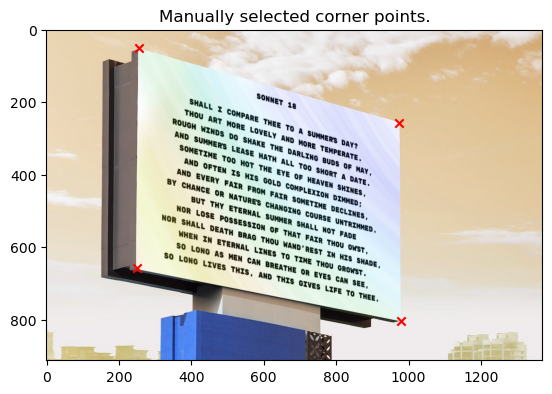

In [98]:
# Answer here
import numpy as np

# manually select 4 corner points from the billboard image
# left-up, right-up, left-down, right-down
corner_points = np.array([[255, 51], [974, 256], [251, 659], [979, 803]],dtype="float32")

plt.figure()
init_img = cv2.imread('data/sonnet18_board.jpg')
plt.imshow(init_img)
plt.scatter(corner_points[:,0], corner_points[:,1], marker='x', color='r')
plt.title('Manually selected corner points.')

Text(0.5, 1.0, 'Perspective transformed image.')

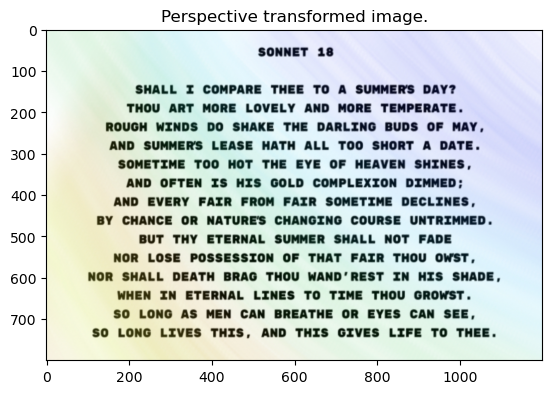

In [99]:
# compute transform matrix
width, height = 1200, 800 #set width and height for img after transform
target_corner_points = np.array([[0,0],[width,0],[0,height],[width,height]], dtype="float32")
matrix = cv2.getPerspectiveTransform(corner_points,target_corner_points)
# show the img after perspective transform
perspective_img = cv2.warpPerspective(init_img, matrix, (width,height))
cv2.imwrite('./output_img/perspective_img.png', perspective_img)
plt.figure()
plt.imshow(perspective_img)
plt.title('Perspective transformed image.')

### 2) Image mosaic from the pieces of sonnet 23. (30 points)
Pieces of sonnet 23: `data/sonnet23_piece1.png`, `data/sonnet23_piece2.png`, `data/sonnet23_piece3.png`, `data/sonnet23_piece4.png`

Feature detection and matching algorithms typically perform better on grayscale images. Grayscale images reduce computational complexity and avoid interference caused by color information when we use ORB detector. 

In [100]:
def Img_mosaic(img1_color, img2_color):
    img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)
    # initial ORB detector
    orb = cv2.ORB_create()

    # detecting keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # using BFMatcher for matching
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # draw the top 50 matching points
    matches_img = cv2.drawMatches(img1_color, kp1, img2_color, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # cv2.imshow("Stitched Image", img_matches)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # cv2.waitKey(1)

    # extract the position of matching points
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
    for j, match in enumerate(matches):
        # `match.queryIdx` is the key point index of the matching item in the first image
        points1[j, :] = kp1[match.queryIdx].pt
        # `match.trainIdx` is the key point index of the matching item in the first image
        points2[j, :] = kp2[match.trainIdx].pt

    # using homography matrix for image stitching
    H, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

    # calculate the four corners of the transformed image
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    corners2_ = cv2.perspectiveTransform(corners2, H)

    # merge the four corners of two images and find the size of the new image
    all_corners = np.concatenate((corners2_, corners1), axis=0)
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    # transform img2 and concatenate img1 onto the transformed image only at non-black pixels
    output_img = cv2.warpPerspective(img2_color, H_translation.dot(H), (x_max - x_min, y_max - y_min))
    # Create a mask for img1
    mask = img1 > 0
    mask_indices = np.where(mask)
    for y, x in zip(mask_indices[0], mask_indices[1]):
        output_img[translation_dist[1] + y, translation_dist[0] + x] = img1_color[y, x]

    # cv2.imshow("Mosaiced Image", output_img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # cv2.waitKey(1)
    return matches_img, output_img

In [101]:
# read imgs
imgs = [cv2.imread('data/sonnet23_piece%d.png'%(i+1),) for i in range(4)]

# mosaic one by one
img = imgs[0]
for i in range(1,len(imgs)):
    matches_img, output_img = Img_mosaic(img, imgs[i])
    cv2.imwrite('./output_img/match_points%d.png'%(i+1), matches_img)
    cv2.imwrite('./output_img/mosaiced_image%d.png'%(i+1), output_img)
    img = output_img

* If we mosaic the images one by one, then the first three images can be successful mosaiced but the 4th image will fail since similar words appear repeatedly in the first three images. See in `output_img/match_points4.png` and `output_img/mosaiced_image4.png`.

    <div style="display: flex; justify-content: space-between;">
        <img src="output_img/match_points4.png" alt="Image 1" style="width: 48%;"/>
        <img src="output_img/mosaiced_image4.png" alt="Image 2" style="width: 48%;"/>
    </div>

* So we mosaic the two up-images together and the two down-images together firstly, and then mosaic these two parts. 

Text(0.5, 1.0, 'Mosaiced image.')

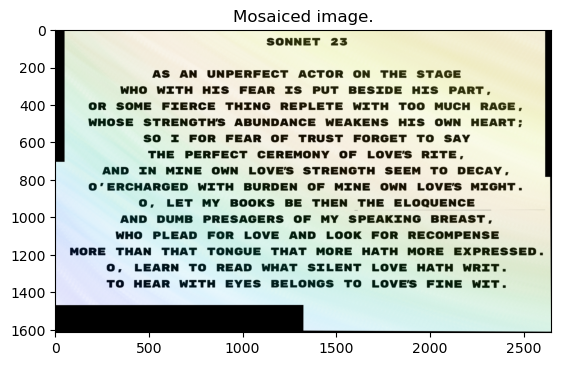

In [102]:
# mosaic up and down
_, img_up = Img_mosaic(imgs[0],imgs[1])
cv2.imwrite('./output_img/mosaiced_image_up.png', img_up)
_, img_down = Img_mosaic(imgs[2],imgs[3])
cv2.imwrite('./output_img/mosaiced_image_down.png', img_down)
_, img_full = Img_mosaic(img_up,img_down)
cv2.imwrite('./output_img/mosaiced_image_full.png', img_full)
plt.figure()
plt.imshow(img_full)
plt.title('Mosaiced image.')

### 3) Locate the words and phrase of the template images in the two generated images. (40 points)
Template images: `data/template_love.png`, `data/template_summer.png`, `data/template_eternal_summer.png`

* I choose to use the template matching to locate the words in the two generated images. There are two important methods in the progress:
  
  * **Multi-scale template matching:** Using cv2. matchTemplate for template matching is not very robust. When the size of the template does not match the size on the detection image, it will face error detection. So I need to traverse different scaling ratios, match templates for each scaling ratio, and record the best match value and position.
  
  * **Select appropriate threshold:** Through testing, it was found that ideal localization results can be achieved when the threshold is set to $val_{max} - 0.05$, where $val_{max}$ is the best(max) matching value.

In [114]:
def Template_matching(img, template, threshold):
    # convert to gray image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    # define the range of multi-scale template matching
    scale_factors = np.linspace(0.2, 1, 20)

    # find the best matching scale
    best_match_val = threshold
    best_scale = 1.0
    all_matches = []
    for scale in scale_factors:
        scaled_template = cv2.resize(template, None, fx=scale, fy=scale)
        res = cv2.matchTemplate(img_gray, scaled_template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if max_val > best_match_val:
            best_match_val = max_val
            best_scale = scale
            loc = np.where(res >= max_val-0.05)
            all_matches = [pt for pt in zip(*loc[::-1])]

    # draw a rectangular box to mark all matching areas
    img_with_rectangles = img.copy()
    for pt in all_matches:
        w, h = (int(template.shape[1] * best_scale), int(template.shape[0] * best_scale))
        cv2.rectangle(img_with_rectangles, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
    
    return img_with_rectangles

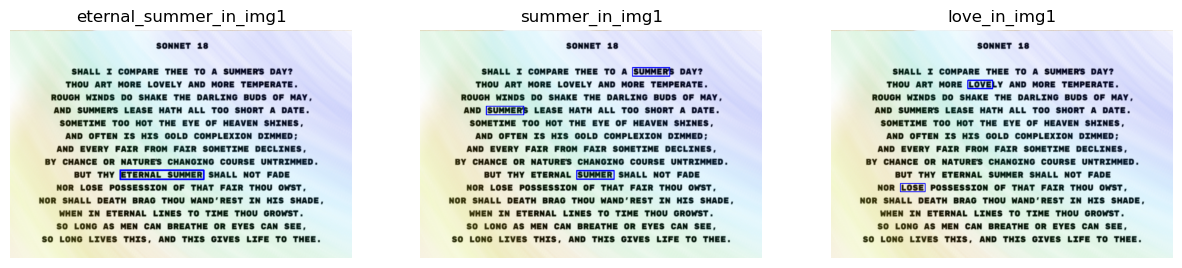

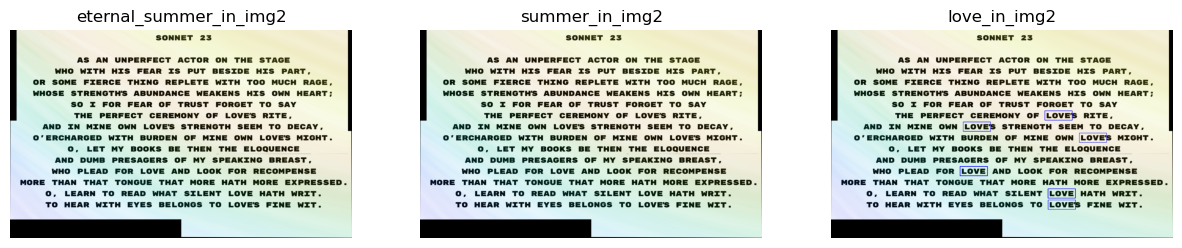

In [117]:
# read result img from 1) and 2) and template
imgs = [cv2.imread('./output_img/perspective_img.png'), cv2.imread('./output_img/mosaiced_image_full.png')]
thresholds = [0.5, 0.9]
template_words = ['eternal_summer', 'summer', 'love']
templates = [cv2.imread('./data/template_'+s+'.png') for s in template_words]

for i in range(len(imgs)):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for j in range(len(templates)):
        result_img = Template_matching(imgs[i], templates[j], thresholds[i])
        title = template_words[j]+'_in_'+'img%d'%(i+1)
        axes[j].imshow(result_img)
        axes[j].set_title(title)
        axes[j].axis('off')
        cv2.imwrite('./output_img/'+title+'.png', result_img)
    plt.show()

### 4) Explain your method and discuss the results. (10 points)
Answer here